# Pre Requisites

In [1]:
#Utilize some helper functions saved in a separate file
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Preparing the Data

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization

In [3]:
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility frac =1 means the whole dataset is shuffled
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# no target column in test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts() #Fairly Balanced dataset and it's a Binary Classification Problem

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# Total number of samples
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples:     {len(test_df)}")
print(f"Total samples:          {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples:     3263
Total samples:          10876


# View 5 random samples

In [9]:
#random training examples

random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():# '5' coz we're picking 5 samples and we don't want the index to go out of bounds
  _, text, target = row #ignore the first column
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
The Latest: More homes razed by Northern California wildfire: The latest on wildfires burning in California andÛ_ http://t.co/0Keh2TReNy

---

Target: 0 (not real disaster)
Text:
I'm a tornado looking for a soul to take

---

Target: 1 (real disaster)
Text:
Coming later this year~ 'THE MAN THAT TATTOOED WOMEN.' A novel based on a real serial killer from #Arkansas &amp; a natural disaster. #NOLA

---

Target: 1 (real disaster)
Text:
#FunnyNews #Business Watch the moment a cliff collapses as huge chunks of rock fall onto a road in China  http://t.co/LCi3pljX25

---

Target: 0 (not real disaster)
Text:
Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Dbcpwd9u

---



# Split into training and validation data

In [10]:


# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
train_sentences[:10], train_labels[:10]   #sentences in text form and labels in numerical form

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Text Vectorization

In [13]:
import tensorflow as tf
#from tensorflow.keras.layers import TextVectorization

In [14]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [15]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                     #   standardize="lower_and_strip_punctuation",
                                    #  split="whitespace", # how to split tokens
                                    # ngrams=None, # create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [16]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [17]:
# Create sample sentence and tokenize it
sample_sentence = "There's a volcanic eruption in the area!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3, 6980, 2472,    4,    2,  408,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

The above text has been vectorized to 15 units and 7 words, rest are padded with zero

In [18]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
'The man who can drive himself further once the effort gets painful is the man who will win.' 
Roger Bannister      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   2,   89,   65,   71,  955, 1661, 2983,  838,    2, 2479,  742,
        9991,    9,    2,   89]], dtype=int64)>

In [19]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() #already assigned as max_tokens=max_vocab_length
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [20]:
words_in_vocab #goes from most commonly used to rarely used

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'with',
 'it',
 'that',
 'at',
 'by',
 'this',
 'from',
 'be',
 'are',
 'was',
 'have',
 'like',
 'as',
 'up',
 'so',
 'just',
 'but',
 'me',
 'im',
 'your',
 'not',
 'amp',
 'out',
 'its',
 'will',
 'an',
 'no',
 'has',
 'fire',
 'after',
 'all',
 'when',
 'we',
 'if',
 'now',
 'via',
 'new',
 'more',
 'get',
 'or',
 'about',
 'what',
 'he',
 'people',
 'news',
 'been',
 'over',
 'one',
 'how',
 'dont',
 'they',
 'who',
 'into',
 'were',
 'do',
 'us',
 '2',
 'can',
 'video',
 'emergency',
 'there',
 'disaster',
 'than',
 'police',
 'would',
 'his',
 'still',
 'her',
 'some',
 'body',
 'storm',
 'crash',
 'burning',
 'suicide',
 'back',
 'man',
 'california',
 'why',
 'time',
 'them',
 'had',
 'buildings',
 'rt',
 'first',
 'cant',
 'see',
 'got',
 'day',
 'off',
 'our',
 'going',
 'nuclear',
 'know',
 'world',
 'bomb',
 'fires',
 'love',
 'killed',
 'go',
 'attack',
 'youtube',
 'dead

## Now to Embedding layer

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding


In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@fewmoretweets all lives matter. Just not a fan of burning down buildings and stealing from your neighbors to 'protest'      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03977952, -0.03782602, -0.03646283, ...,  0.00236253,
          0.03332629,  0.02803668],
        [-0.04755558,  0.01773831, -0.03848469, ..., -0.03399577,
         -0.04253842, -0.04712509],
        [ 0.03603521, -0.01872348,  0.00094754, ...,  0.03704604,
         -0.02932191,  0.01167182],
        ...,
        [ 0.02248487, -0.02848336,  0.04786098, ...,  0.03069806,
         -0.04317403, -0.04145076],
        [ 0.01736889,  0.02054228,  0.03813318, ...,  0.00564801,
         -0.00274082, -0.04247797],
        [-0.03769413, -0.00289064, -0.03677417, ..., -0.04211248,
         -0.03247404,  0.04107854]]], dtype=float32)>

The above Embedding version is a learned representation of numbers that get initialized randomly but learn as they pass through the network

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.03977952, -0.03782602, -0.03646283, -0.02449075, -0.00015752,
        0.02220254,  0.00162981,  0.00603487,  0.0085157 , -0.02620113,
        0.04101599,  0.03715892,  0.02397566,  0.00281113, -0.02704906,
       -0.04870148,  0.01457943,  0.0059551 , -0.02334484,  0.03581132,
        0.04377897,  0.04186075,  0.03245703, -0.045092  ,  0.04260418,
        0.03398135, -0.01812425, -0.03539513,  0.02954218,  0.02556742,
       -0.03345481,  0.04272738, -0.00798845, -0.0406163 , -0.00644834,
        0.00232404,  0.01703629,  0.03645121, -0.02622857,  0.03498118,
       -0.03059715,  0.02576998, -0.04221511,  0.02654583, -0.02192564,
       -0.0346157 ,  0.00075326,  0.01427345,  0.01027539, -0.04311384,
       -0.03973336, -0.00966626,  0.01032177, -0.04011822, -0.018892  ,
       -0.01233201,  0.02721632, -0.01232889, -0.02504088, -0.04715574,
        0.00558523, -0.00801403,  0.03058865, -0.01923352, -0.04175536,
       -0.036542

# Creating a baseline model using traditional ML (Naive Bayes) model 0

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Creating a Simple Dense Model 1

In [29]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [30]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # sigmoid squashes any input value to a range between 0 and 1
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [31]:
# Compile model
model_1.compile(loss="binary_crossentropy", #used in binary problems when the output is 0 or 1
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

The 1280129 parameters are coz of 128 dim embeddings into 10,000 max tokens/vocab size

In [33]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20250307-034121
Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [34]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 1ms/step - loss: 0.4767 - accuracy: 0.7874


[0.47668465971946716, 0.787401556968689]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073164,  0.01504797, -0.03425452, ..., -0.04403543,
         -0.01042278,  0.01876435],
        [ 0.04135864, -0.03945082, -0.03811941, ...,  0.00464735,
          0.03163553,  0.02928305],
        [ 0.00684032,  0.05363133, -0.00241555, ..., -0.07082175,
         -0.04750698,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692342,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018394,  0.0351042 ],
        [-0.0372346 ,  0.06267188, -0.07451148, ..., -0.02367217,
         -0.08643331,  0.01742156]], dtype=float32)>]

In [36]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)   # for 10k max vocab and 128 dim vectors...

(10000, 128)


In [37]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 1ms/step


array([[0.404882  ],
       [0.7443312 ],
       [0.997895  ],
       [0.10889997],
       [0.1114353 ],
       [0.9355609 ],
       [0.9134594 ],
       [0.99253446],
       [0.9715681 ],
       [0.2657034 ]], dtype=float32)

In [38]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [40]:
# Is our simple Dense model better than our baseline Naive bayes model?
# checking the values of accuracy, precision, recall and f1 score
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [41]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights) #updated weights as the model learns
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

[[ 0.00073164  0.01504797 -0.03425452 ... -0.04403543 -0.01042278
   0.01876435]
 [ 0.04135864 -0.03945082 -0.03811941 ...  0.00464735  0.03163553
   0.02928305]
 [ 0.00684032  0.05363133 -0.00241555 ... -0.07082175 -0.04750698
   0.01448254]
 ...
 [-0.03301444 -0.0052493  -0.04209725 ...  0.02028764  0.00308807
   0.02215792]
 [ 0.00692342  0.05942352 -0.01975194 ... -0.06199061 -0.01018394
   0.0351042 ]
 [-0.0372346   0.06267188 -0.07451148 ... -0.02367217 -0.08643331
   0.01742156]]
(10000, 128)


In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

# Creating Model 2 with LSTM

In [45]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell\ relu makes -ve into 0, if +ve remains unchanged
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [46]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20250307-034137
Epoch 1/5
215/215 [==============================] - 10s 25ms/step - loss: 0.5105 - accuracy: 0.7475 - val_loss: 0.4579 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3205 - accuracy: 0.8701 - val_loss: 0.4992 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2233 - accuracy: 0.9145 - val_loss: 0.5533 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1621 - accuracy: 0.9432 - val_loss: 0.6374 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1118 - accuracy: 0.9585 - val_loss: 0.8779 - val_accuracy: 0.7638


In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [49]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 4ms/step


((762, 1),
 array([[1.7079480e-02],
        [6.6736013e-01],
        [9.9978411e-01],
        [3.3760622e-02],
        [8.3615648e-04],
        [9.9988747e-01],
        [8.7640941e-01],
        [9.9992561e-01],
        [9.9987233e-01],
        [1.9446409e-01]], dtype=float32))

In [50]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [51]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 0.766310461192351,
 'recall': 0.7637795275590551,
 'f1': 0.7610762606610089}

In [52]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.38, Difference: -2.89
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


# Creating Model 3 using GRU

In [53]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [54]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                       

In [56]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20250307-034204
Epoch 1/5
215/215 [==============================] - 9s 22ms/step - loss: 0.5240 - accuracy: 0.7348 - val_loss: 0.4501 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3249 - accuracy: 0.8662 - val_loss: 0.4909 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2244 - accuracy: 0.9155 - val_loss: 0.5359 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1628 - accuracy: 0.9432 - val_loss: 0.6398 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1215 - accuracy: 0.9594 - val_loss: 0.6044 - val_accuracy: 0.7703


In [57]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


((762, 1),
 array([[0.30182013],
        [0.79580885],
        [0.99748313],
        [0.17182574],
        [0.0114118 ],
        [0.99277   ],
        [0.64600194],
        [0.99678236],
        [0.99766237],
        [0.25952685]], dtype=float32))

In [58]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7701965974536404,
 'recall': 0.7703412073490814,
 'f1': 0.7694283709964855}

In [60]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Model 4 using BiDirectional RNN

In [61]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [62]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                             

In [64]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20250307-034230
Epoch 1/5
215/215 [==============================] - 14s 29ms/step - loss: 0.5057 - accuracy: 0.7501 - val_loss: 0.4546 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3115 - accuracy: 0.8768 - val_loss: 0.5145 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2098 - accuracy: 0.9187 - val_loss: 0.5697 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1417 - accuracy: 0.9512 - val_loss: 0.6899 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1012 - accuracy: 0.9667 - val_loss: 0.7046 - val_accuracy: 0.7664


In [65]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.00695204],
       [0.8773243 ],
       [0.99736065],
       [0.13291574],
       [0.00910186],
       [0.997924  ],
       [0.82542646],
       [0.9994547 ],
       [0.9984187 ],
       [0.1746117 ]], dtype=float32)

In [66]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.771218657508237,
 'recall': 0.7664041994750657,
 'f1': 0.7627908927491446}

In [68]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


# Model 5 using Cov1D

In [69]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")



In [70]:
# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [71]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20250307-034304
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.5559 - accuracy: 0.7116 - val_loss: 0.4681 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3114 - accuracy: 0.8781 - val_loss: 0.5056 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1641 - accuracy: 0.9447 - val_loss: 0.5470 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1025 - accuracy: 0.9680 - val_loss: 0.6080 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0768 - accuracy: 0.9762 - val_loss: 0.6318 - val_accuracy: 0.7835


In [72]:

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 64)             

In [73]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 1ms/step


array([[0.25945702],
       [0.7059047 ],
       [0.999485  ],
       [0.05618268],
       [0.00756932],
       [0.99552774],
       [0.89148456],
       [0.99517894],
       [0.9983709 ],
       [0.15831214]], dtype=float32)

In [74]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.34645669291339,
 'precision': 0.7872123378365872,
 'recall': 0.7834645669291339,
 'f1': 0.7807800582578167}

In [76]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.35, Difference: -0.92
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# Model 6: TensorFlow Hub Pretrained Sentence Encoder¶

In [77]:
# Sentence encoder creating embedding for whole sentence instead of just word level like we did for previous models
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder


In [78]:
embed_samples = embed([sample_sentence,
                      "This is a sample sentence where when you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01919626  0.03580806 -0.01051746  0.00803717  0.03318942 -0.01937674
  0.05923755 -0.00114248  0.0269969   0.03682643  0.02981899  0.00664008
  0.00420282  0.06707849  0.00270443 -0.05176902 -0.0445304  -0.02926458
 -0.01439998 -0.02365554 -0.04606229 -0.00337202  0.02348704  0.08446364
 -0.05276516 -0.0546678   0.03179989  0.01261172 -0.02797169 -0.00228025
 -0.06416498 -0.03120591 -0.04923686  0.03188515 -0.0081309   0.07574863
 -0.03623925  0.07664614  0.01958211  0.00083611 -0.05661529  0.02020875
  0.00689054  0.05636149 -0.08412047  0.01122623  0.01917547 -0.03058512
  0.05984719 -0.0452032 ], shape=(50,), dtype=float32)


In [79]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [80]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (to create a feature extractor for next model)
                                        name="UniversalSentenceEncoder") 

In [81]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")



In [82]:
# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [83]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UniversalSentenceEncoder (K  (None, 512)              256797824 
 erasLayer)                                                      
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [84]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20250307-034340
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.5100 - accuracy: 0.7824 - val_loss: 0.4448 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.4345 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4000 - accuracy: 0.8218 - val_loss: 0.4305 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3926 - accuracy: 0.8259 - val_loss: 0.4269 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3863 - accuracy: 0.8304 - val_loss: 0.4288 - val_accuracy: 0.8110


In [85]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.15300062],
       [0.73603505],
       [0.98860794],
       [0.19721143],
       [0.7298595 ],
       [0.6702608 ],
       [0.98279464],
       [0.98031515],
       [0.92465436],
       [0.09441808]], dtype=float32)

In [86]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [87]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8140341548215564,
 'recall': 0.8110236220472441,
 'f1': 0.809201931950287}

In [88]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.10, Difference: 1.84
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


# Model 7 using TensorFlow Hub Pretrained Sentence Encoder 10% of the training data


In [89]:
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [90]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [91]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [92]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

In [93]:
# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [94]:
# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UniversalSentenceEncoder (K  (None, 512)              256797824 
 erasLayer)                                                      
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [95]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20250307-034400
Epoch 1/5
22/22 [==============================] - 5s 32ms/step - loss: 0.6691 - accuracy: 0.6691 - val_loss: 0.6485 - val_accuracy: 0.7244
Epoch 2/5
22/22 [==============================] - 0s 11ms/step - loss: 0.5942 - accuracy: 0.8251 - val_loss: 0.5879 - val_accuracy: 0.7493
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 0.5158 - accuracy: 0.8222 - val_loss: 0.5355 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 0s 13ms/step - loss: 0.4524 - accuracy: 0.8411 - val_loss: 0.5050 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 0s 12ms/step - loss: 0.4096 - accuracy: 0.8426 - val_loss: 0.4883 - val_accuracy: 0.7703


In [96]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.23453255],
       [0.807578  ],
       [0.9157539 ],
       [0.30399552],
       [0.55507994],
       [0.83616275],
       [0.82034314],
       [0.85693026],
       [0.84923124],
       [0.12980618]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7751330918759862,
 'recall': 0.7703412073490814,
 'f1': 0.7668707484010339}

In [99]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Comparing the performance of each of our models

In [100]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,76.377953,0.766310,0.763780,0.761076
gru,77.034121,0.770197,0.770341,0.769428
bidirectional,76.640420,0.771219,0.766404,0.762791
conv1d,78.346457,0.787212,0.783465,0.780780
tf_hub_sentence_encoder,81.102362,0.814034,0.811024,0.809202
tf_hub_10_percent_data,77.034121,0.775133,0.770341,0.766871


In [101]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

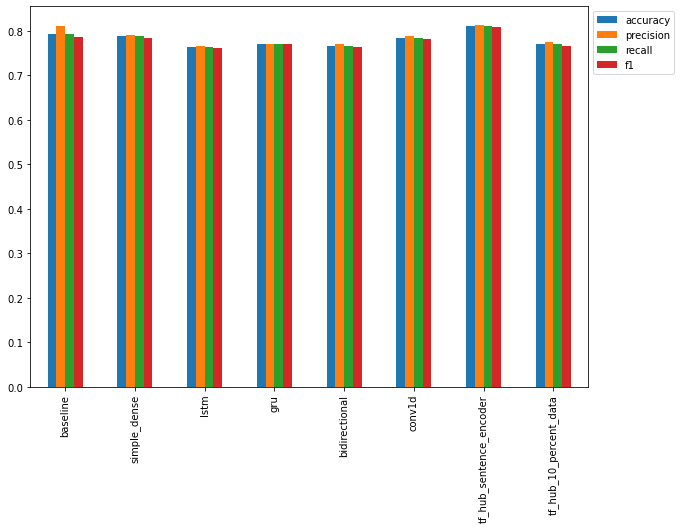

In [102]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

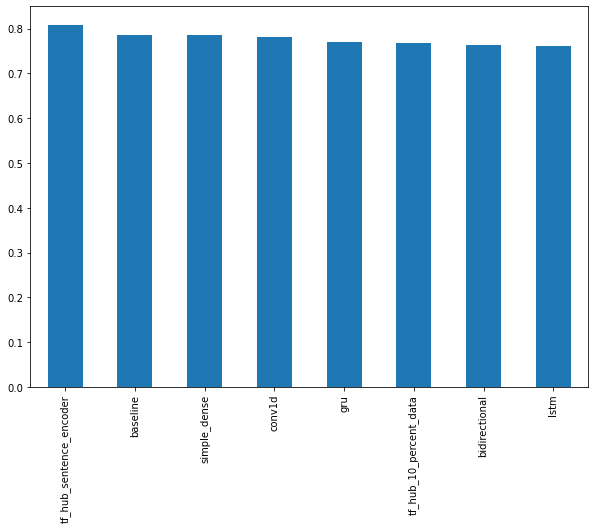

In [103]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Combining our models

In [104]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [105]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 77.82152230971128,
 'precision': 0.7779066800449299,
 'recall': 0.7782152230971129,
 'f1': 0.7776698015840804}

In [106]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [107]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [108]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.763780,0.766310,0.763780,0.761076
gru,0.770341,0.770197,0.770341,0.769428
bidirectional,0.766404,0.771219,0.766404,0.762791
conv1d,0.783465,0.787212,0.783465,0.780780
tf_hub_sentence_encoder,0.811024,0.814034,0.811024,0.809202
tf_hub_10_percent_data,0.770341,0.775133,0.770341,0.766871
ensemble_results,0.778215,0.777907,0.778215,0.777670


# Saving and loading a trained model (Model 6 the best results)

In [109]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [110]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [111]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 4s 25ms/step - loss: 0.4288 - accuracy: 0.8110


[0.428787499666214, 0.8110235929489136]

In [112]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format\assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format\assets


In [113]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [114]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 6ms/step - loss: 0.4288 - accuracy: 0.8110


[0.428787499666214, 0.8110235929489136]

# Randomly getting samples from test dataset and predicting on it

In [115]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  if int(pred)==1:
        print("Disaster")
  else:
    print("Not Disaster")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 51ms/step
Pred: 1, Prob: 0.9617922306060791
Disaster
Text:
3 former executives to be prosecuted in Fukushima nuclear disaster http://t.co/EmWU8Xksdu

----

1/1 [==============================] - 0s 38ms/step
Pred: 1, Prob: 0.9404222369194031
Disaster
Text:
And Kolkata is struck by a Cyclonic Storm. Sumthng big is gonna happen 2day evng. Heavy rains nd a violent storm approachng. God help us.

----

1/1 [==============================] - 0s 28ms/step
Pred: 1, Prob: 0.9685485363006592
Disaster
Text:
OMG there's a news chopper over a 3-acre mostly contained fire outside Forest Grove? #slownewsday ?

----

1/1 [==============================] - 0s 49ms/step
Pred: 0, Prob: 0.04910268262028694
Not Disaster
Text:
@asda bought this bargain dress and love it- cut colour pattern. Are you doing more? http://t.co/BnZm8K2AiM

----

1/1 [==============================] - 0s 80ms/step
Pred: 1, Prob: 0.7682335376739502
Disaster
Text:
Arsonist Sets NYC Vegetari

In [119]:
import tensorflow as tf

vectorizer_model = tf.keras.Sequential([text_vectorizer])
vectorizer_model.save('text_vectorizer', save_format='tf')


INFO:tensorflow:Assets written to: text_vectorizer\assets


INFO:tensorflow:Assets written to: text_vectorizer\assets
